In [5]:
# Approximating Sobol' indices (MeFAST)
# Authors: Zahra Aminzare, Kerry Tarrant
# Source(s): 
#   (1) Dela, A., Shtylla, B., & Pillis, L.D. (2022). "Supplementary Information
#           Multi-method Global Sensitivity Analysis in Mathematical Models."
#   (2) https://github.com/an-do/MeFAST

# Access on Google Colab: https://colab.research.google.com/drive/1RXC5OYV7MeuO3QGb2jGdxirUmzpUj7IG?usp=sharing

# Note: Not usable with Python3 versions < 3.8. Requires scipy version >= 1.8.0
#       Consider running in Anaconda instead of Google Colab.

# Initialization

In [6]:
import numpy as np
from scipy.integrate import solve_ivp

## Packages might break plots. Affects Anaconda runs.
# import torch

from scipy import stats
from scipy.stats import norm
from scipy.stats import ks_2samp
from scipy.stats import tukey_hsd
from scipy.stats import ranksums
from scipy.stats import permutation_test

## Two or more groups
from scipy.stats import f_oneway

import math

from tempfile import TemporaryFile
outfile = TemporaryFile()

from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

import random
import time

# Latin Hypercube Sampling

In [7]:
def LHS_Call(xmin,
             xmean,
             xmax,
             xsd,
             Nsample,
             distribution,
             threshold):
    
    if Nsample==1:
        s=xmean
        return s

    if np.isscalar(xmean):
        Nparams=1
        xmean=np.array([xmean])
        xsd=np.array([xsd])
    else:
        Nparams=len(xmean)

    if distribution=='norm':
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            s[:,j] = xmean[j] + norm.ppf[P]*xsd[j]        

    if distribution=='unif':
        if xmin==0:
            xmin=1e-300
        if np.isscalar(xmin):
            Nparams=1
            xmin=np.array([xmin])
            xmax=np.array([xmax])
        else:
            Nparams=len(xmin)
        ran=np.random.uniform(low=0,high=1,size=(Nsample,Nparams))
        s=np.zeros((Nsample,Nparams))
        for j in range(Nparams):
            idx=np.random.permutation(Nsample)
            P=(idx.T - ran[:,j])/Nsample
            if (xmax[j]<1 and xmin[j]<1) or (xmax[j]>1 and xmin[j]>1):
                # Same range
                if (xmax[j]/xmin[j])<threshold:
                    #
                    s[:,j]=xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(abs(np.log(xmax[j])) - abs(np.log(xmin[j])))
                    s[:,j] = np.exp(s[:,j])
            else:
                if (xmax[j]/xmin[j])<threshold:
                    s[:,j] = xmin[j] + P*(xmax[j]-xmin[j])
                else:
                    s[:,j] = np.log(xmin[j]) + P*abs(np.log(xmax[j]) - np.log(xmin[j]))
                    s[:,j] = np.exp(s[:,j])
    if np.shape(s)[1]==1:
        return s.flatten()
    else:
        return s

# Conditional matrices

In [8]:
def conditional_matrices(mat_A,mat_B):
    Nparams=len(A[0,:])
    # C_i: same as matrix A but replace the ith column of A with the ith column of B
    C = []
    for index in range(Nparams):
        C_i = mat_A.copy()
        C_i[:,index] = mat_B[:,index].copy()
        C.append(C_i.copy())

    # D_i: same as matrix B but replace the ith column of B with the ith column of A
    D = []
    for index in range(Nparams):
        D_i = mat_B.copy()
        D_i[:,index] = mat_A[:,index].copy()
        D.append(D_i.copy())
    return C, D

# Parameters from a uniform distribution with resampling

In [9]:
def repeat_rand(array,
                integer):
    
    rng = np.random.default_rng()
    array = np.repeat(array,integer)
    rng.shuffle(array)
    array = array.reshape(-1,1)

    return array

# Sobol' Method Algorithm

In [10]:
## Variance of the conditional expectation VCE
def var_Y(Y_A,
          Y_B):
    N = len(Y_A)
    mu_Y_A = np.mean(Y_A)
    mu_Y_B = np.mean(Y_B)
    var = (1/(2*N))*np.sum(
        (Y_A - mu_Y_A)**2 + (Y_B - mu_Y_B)**2
        )
    return var

# Total variance
def var_total(Y_A,
              Y_B):
    Y = np.vstack((np.reshape(Y_A, (-1,1)), np.reshape(Y_B, (-1,1))))
    N = len(Y[:,0])
    mu_Y = np.mean(Y)
    var = (1/N)*np.sum((Y-mu_Y)**2)
    return var

## Variance of expectation of output given fixed parameter
def var_e_Y_given_Xi(Y_A,
                     Y_B,
                     Y_C):
    N = len(Y_A)
    var = (1/N)*np.sum(Y_B*np.abs(Y_C-Y_A)) # abs from Sobol_HIV_main.m
    return var

## Expectation of variance of output given all other parameters
def e_var_Y_given_notXi(Y_A,
                        Y_C):
    N = len(Y_A)
    var = (1/(2*N))*np.sum((Y_A-Y_C)**2)
    return var

# eFAST

In [11]:
# Algorithm for selection of a frequency set for the complementary group. Done 
# recursively as described in Appendix of "Sensitivity Analysis" [Saltelli et 
# al., 2000].

# Sampling procedure in eFAST.

# Returns:
# OMci = SETFREQ(k-1,OMi/2/MI)
# Note: The ith parameter is replaced outside this function.

def SETFREQ(Kci,    # Number of parameters (not the number of complementary 
                    # parameters)
            OMciMAX # Maximum allowable frequency of complement set
            ):
    
    if Kci == 1:
        OMci = 1
    elif OMciMAX == 1:
        OMci = np.ones(Kci)
    else:
        if OMciMAX < Kci:
            INFD = OMciMAX
        else:
            INFD = Kci

        # Step between assigned frequencies.
        ISTEP = int(round( (OMciMAX-1)/(INFD-1) ))

        if OMciMAX == 1:
            ISTEP = 0
        OTMP = np.arange(0, INFD*ISTEP, ISTEP)
        fl_INFD = math.floor(INFD)
        OMci = np.array([])
        for i in range(Kci):

            # Parameter index
            j = int(i-1 % int(fl_INFD))

            # Assign parameter with frequency
            OMci = np.append(OMci, OTMP[j])

    return OMci

In [12]:
# Parameter distributions for eFSAT sampling scheme.

# The uniform pdf implements a log scale for pmax/pim>1e4.

def parameterdist(  X,           # Array: efast search curves normalized between 
                                 # 0 and 1, 
                                 # i.e. [X(:,:,i,L) = 0.5+asin(sin(ANGLE'))/pi
                    pmax, pmin,  # Arrays: min and max values of the range of 
                                 # variation
                    pmean, pstd, # mean and standard deviation for distributions
                                 # other than uniform
                    Nsample,     # number of samples (usually 65 in efast)
                    distribution # type of distributions (pdf). 
                                 # Uniform ['unif'], nomral ['norm'], 
                                 # lognormal ['lognorm']
                  ):
    if np.isscalar(pmax):
        pmax=np.array([pmax])
    else:
        pass
    if np.isscalar(pmin):
        pmin=np.array([pmin])
    else:
        pass
    if np.isscalar(pmean):
        pmean=np.array([pmean])
    else:
        pass
    if np.isscalar(pstd):
        pstd=np.array([pstd])
    else:
        pass
    Xdist = np.zeros_like(X)
    if distribution == 'unif':

        # Loop through parameters
        for k in range(len(X[0,:])):
            nvar = len(pmin)
            ran = np.random.rand(Nsample,1).reshape((-1,1))
            s = np.zeros((Nsample,1))
            idx = np.random.permutation(Nsample).reshape((-1,1))
            P = (idx - ran)/Nsample
            Xdist[:,k] = (X[:,k] * (pmax[k]-pmin[k])) + pmin[k]

    elif distribution == 'norm':

        # Loop through parameters
        for k in range(len(X[0,:])):
            Xdist[:,k] = norm.ppf(X[:,k],loc=pmin[k],scale=pstd[k])

    elif distribution == 'lognorm':
        
        # Loop through parameters
        for k in range(len(X[0,:])):
            Xdist[:,k] = norm.ppf(X[:,k], np.log(pmean[k]), pstd[k])

    else:
        print('Error: Specify pdf in parameterdist.')
        return
        
    return Xdist

In [13]:
def compute_variance(Y,   # Array: Matrix at given time points
                     OMi, # Integer: Frequency of parameter of interest
                     MI   # Integer: Maximum number of Fourier coefs in 
                          # calculating partial variance.
                     ):
    
    # Take mean along columns of Y
    # Subtract from Y
    # Transpose
    Y = (Y - np.mean(Y, axis=0)).T

    # Fourier coeff. at [1:OMi/2].

    # Number of rows (runs / number of parameter points) in Y
    N = len(Y)

    NQ = math.floor((N-1)/2)
    N0 = math.floor(NQ+1)
    COMPL = 0

    # Meditate on the indexing here. The original code is from MATLAB which 
    # indexes array entries differently than python.

    # Var(E(Y_~i)) plus
    Y_VECP = Y[N0+np.arange(0,NQ)] + Y[N0-np.arange(0,NQ)]
    # Var(E(Y_~i)) minus
    Y_VECM = Y[N0+np.arange(0,NQ)] - Y[N0-np.arange(0,NQ)]

    for j in range(int(OMi/2)):

        # Different from S_VEC in sampling routine. // From equations 10 and 11
        # in (3) we have p * w_i * s and not w_i * s + phi_i.
        ANGLE = j*2*np.arange(0,NQ)*np.pi/N
        C_VEC = np.cos(ANGLE).flatten()
        S_VEC = np.sin(ANGLE).flatten()

        # We do not need to keep AC or BC
        AC = (Y[N0] + np.inner(Y_VECP,C_VEC))/N
        BC = np.inner(Y_VECM,S_VEC)/N

        COMPL = COMPL + AC**2 + BC**2

    # Computation of partial variance V_{(ci)}
    Vci = 2*COMPL

    # Reset COMPL
    COMPL = 0

    # The reason for defining these variables again is unclear since they are
    # the same as above.
    Y_VECP = Y[N0 + np.arange(0,NQ)] + Y[N0-np.arange(0,NQ)]
    Y_VECM = Y[N0 + np.arange(0,NQ)] - Y[N0-np.arange(0,NQ)]

    for j in np.arange(start=OMi,stop=OMi*MI,step=OMi):
        ANGLE = j*2*np.arange(0,NQ)*np.pi/N
        C_VEC = np.cos(ANGLE).flatten()
        S_VEC = np.sin(ANGLE).flatten()

        # We do not need to keep AC or BC
        AC = (Y[N0] + np.inner(Y_VECP,C_VEC))/N
        BC = np.inner(Y_VECM,S_VEC)/N

        COMPL = COMPL + AC**2 + BC**2

    # Computation of V_i
    Vi = 2*COMPL

    # Total variance
    V=np.inner(Y,Y)/N

    # Convert to scalar
    if ~np.isscalar(Vci):
        Vci = Vci.item()
    if ~np.isscalar(Vi):
        Vci = Vi.item()
    if ~np.isscalar(V):
        V = V.item()

    return Vci, Vi, V

In [14]:
def difference_means(x, y):
    return np.mean(np.squeeze(x)) - np.mean(np.squeeze(y))

In [15]:
def model_efast(NR,          # Integer: Number of resampling curves.
                
                pmin, pmax,  # Arrays: Range of parameters.
                
                baseline,    # Array: Baseline values for parameters. Used if 
                             # parameters follow a normal distribution.
                
                time_points, # Array: Time points of interest. In HIV and cancer
                             # the array contains time stamps that are within
                             # the interval of integration. 
                             # Use string 'ss' if only interested in steady state.
                
                params,      # Class: Parameters defined as a class. // Not in 
                             # original code but used for pump leak model since 
                             # only some parameters are being varied.
                
                myfun,       # Function: The ODE system.

                y_var_labels # ODE variables
                ):


    # Time point if only looking for steady state approx.
    if type(time_points)==str:
        time_points=np.array([-1])
        is_ss = True
    elif ~(type(time_points)==str):
        is_ss = False

    # Number of parameters including dummy variable
    Nparams = len(pmin)

    # Number of state variables. 4 state variables for 
    # pump model (Na,K,Cl,w), but only interested in w.
    n_var = len(y_var_labels)

    # Maximum number of fourier coefficients
    MI = 4

    ## Sensitivity indices

    # rangeSi, rangeSti are arrays that store the history of all sensitivity 
    # indices over all NR search curves.

    # If only interested in 1 state variable. (Case 1.)
    if n_var == 1:
        rangeSi = np.zeros((NR, len(time_points), len(pmin)))
        rangeSti = np.zeros((NR, len(time_points), len(pmin)))
    # If interested in more than 1 state variable (Case 2.)
    elif n_var > 1:
        rangeSi = np.zeros((NR, len(time_points), len(pmin), n_var))
        rangeSti = np.zeros((NR, len(time_points), len(pmin), n_var))

    ## Compute Sensitivity index
    # Loop over Nparams (input factors)
    for i in range(Nparams):

        # i is the number of replications (or blocks)

        # Algorithm for selecting the set of frequencies

        # OMci[i], where i is in [0,k-1], contains the set of frequencies to be 
        # used by the complementary group.

        print('Simulating MeFAST sensitivity indices for parameter ',
              i+1, ' out of ', Nparams)
        
        # Seed for random state // reproducible
        np.random.seed(i)

        # Initial random matrix sampled uniformly between 0 and 1
        FI_mat = np.random.rand(NR,Nparams)


        ## Allocation for variance computation
        if n_var == 1:
            # Parital variance contributed by parameter
            Vi = np.zeros((NR, len(time_points)))
            # Partial variance contributed by the complementing parameters
            Vci = np.zeros((NR, len(time_points)))
            # Total variance
            V = np.zeros((NR, len(time_points)))
        elif n_var > 1:
            # Parital variance contributed by parameter
            Vi = np.zeros((NR, len(time_points), n_var))
            # Partial variance contributed by the complementing parameters
            Vci = np.zeros((NR, len(time_points), n_var))
            # Total variance
            V = np.zeros((NR, len(time_points), n_var))
        
        # Loop over the NR seach surves.
        for L in range(NR):

            print('Resampling: ',L+1,' out of ',NR)

            # Number of samples for distribution
            NS = (L+1)*65
            
            # (2): "See Saltelli 1999 for algorithm"

            # Frequency
            OMi = ((NS/(L+1)) - 1)/(2*MI)

            # Complementary frequency
            OM = SETFREQ(Nparams, OMi/2/MI)
            OM[i] = OMi

            FI = (FI_mat[L,:].copy())*2*np.pi
            S_VEC = np.pi*(2*np.arange(0,NS)-NS-1)/NS
            OM_VEC = OM[:Nparams].copy()
            FI_MAT = np.repeat(np.reshape(FI.copy(),(-1,1)), NS, axis=1)
            ANGLE = np.outer(OM_VEC,S_VEC) + FI_MAT.copy()

            # Between 0 and 1
            X = 0.5 + np.arcsin(np.sin(ANGLE.T))/np.pi

            # Transform distributions from standard uniform to general
            mat = parameterdist(X,          # 
                                pmax, pmin, # Min and max param values
                                0,          # Mean
                                1,          # Standard deviation
                                NS,         # Number of samples
                                'unif'      # Models from (2) sample w/ uniform
                                )
            # Ytemp is a matrix array whose row is the number of simulations
            # and number of columns corresponding with model output at each
            # time in time_point.
            Ytemp = np.zeros((NS, len(time_points)*n_var))

            print('Simulating model ',NS,' times')

            # Simulate model NS times
            for run_num in range(NS):

                parameter_point = (mat[run_num,:].copy()).flatten()
                params.pnka  = parameter_point[0]
                params.pnkcc = parameter_point[1]
                params.pkcc  = parameter_point[2]
                params.pncc  = parameter_point[3]

                
                if is_ss:

                    # Simulation time in seconds.
                    # 5 hours might be higher than needed for pump leak.
                    t0   = 0*3600
                    tmax = 5*3600
                    time_points = np.array([tmax])

                    # Initial conditions for pump leak
                    wA0  = params.wA0
                    Oso  = params.Oso
                    a    = 0.2
                    clA0 = (Oso/2) - (xA/wA0)
                    naA0 = a*Oso/2
                    kA0  = (1-a)*Oso/2
                    X_0  = [naA0, kA0, clA0, wA0]

                    # solve_ivp is an ODE solver from the scipy.integrate library.
                    # LSODA is a useful method for stiff problems--used by Aggarwal.
                    # rtol=1e-6 comes from An Dela's Github repository (2).
                    results = solve_ivp(myfun,
                                        (t0, tmax),
                                        X_0,
                                        method='LSODA',
                                        rtol=1e-6,
                                        args=[params]
                                        )

                else:
                    
                    t0   = 0
                    tmax = time_points[-1]
                    teval = np.arange(start=t0, stop=tmax, step=0.5)

                    ## Initial conditions for cancer model
                    X_0 = [0.1,0.003,0]

                    # solve_ivp is an ODE solver from the scipy.integrate library.
                    # LSODA is a useful method for stiff problems--used by Aggarwal.
                    # rtol=1e-6 comes from An Dela's Github repository (2).
                    results = solve_ivp(fun = myfun,
                                        t_span = (t0,tmax),
                                        y0 = X_0,
                                        method = 'LSODA',
                                        rtol = 1e-6,
                                        t_eval = teval,
                                        args = [params]
                                        )

                
                # Event detection // not used in pump leak
                if is_ss:
                    pass
                else:
                    # np.size(results.event) > 0
                    pass



                if len(time_points)==2:
                    # Used in both HIV and cancer models.
                    time_point_0 = time_points[0].copy()
                    time_point_1 = time_points[1].copy()
                    Ytemp[run_num,:] = np.hstack((results.y[results.t==time_point_0],
                                                  results.y[results.t==time_point_1]))
                elif len(time_points)==1:
                    # Used if one time point. Not used in HIV, cancer, or pump
                    # leak models.
                    time_point_0 = time_points[0].copy()
                    Ytemp[run_num,:] = np.squeeze(results.y[:,results.t==time_point_0])


            # end loop - simulate model NS times


            # Ytemp: the rows represent the parameter point. The columns
            # represent the state variable. NaN values are dealt with by
            # deleting the row containing them. This omits that parameter point.

            print('Computing variance and SI for parameter ',
                  i+1,' out of ',Nparams)
                    
            # if/else - Number of state variables
            if n_var == 1: # Case 1: model only tracks data of 1 type of model 
                           # outcome.

                # post processing data // Y[run,t]
                Y = Ytemp.copy()

                # remove any NaN entries // Remove the rows containing a NaN.
                Y = Y[~np.isnan(Y).any(axis=1),:]

                # Loop over time_points
                for u in range(time_points):

                    # Compute variance // Not in original
                    Vci[L,u], Vi[L,u], V[L,u] = compute_variance(np.squeeze(Y[:,u].copy()),OMi,MI)
                    rangeSi[L,u,i]  = Vi[L,u]/V[L,u]
                    rangeSti[L,u,i] = 1-(Vci[L,u]/V[L,u])

                # end loop - time_points

            elif n_var>1: # Case 2: model tracks data of more than 1 type of 
                          # model outcome.

                # Remove any NaN entries // Not in original repo code
                Ytemp = Ytemp[~np.isnan(Ytemp).any(axis=1),:].copy()

                # Post processing data
                # Y is a structure that stores time data of each model output
                Y = np.zeros((len(Ytemp[:,0]), len(time_points), n_var))

                # Loop over y variables
                for yvar in range(n_var):

                    # Re-arange y-data into structure // Y[var,run,t]
                    Y[:,:,yvar] = Ytemp[ :, np.arange(yvar,len(Ytemp[0,:]),n_var) ]

                    # Loop over time_points
                    for u in range(len(time_points)):

                        # Compute variance
                        Vci[L,u,yvar], Vi[L,u,yvar], V[L,u,yvar] = compute_variance(np.squeeze(Y[:,u,yvar].copy()),OMi,MI)
                        rangeSi[L,u,i,yvar]  = Vi[L,u,yvar]/V[L,u,yvar]
                        rangeSti[L,u,i,yvar] = 1-(Vci[L,u,yvar]/V[L,u,yvar])

                    # end loop - u (time_points)

                # end loop - y_var (y variables)

            # if/else - (n_var) number of variables

        # end loop - L (search curves)

    # end loop - i (Compute sensitivity indices (Nparams (input factors))

    np.savez('efast_pump_leak_data.npz',        # File name
             Si=rangeSi, Sti=rangeSti           # Array saved to file with the 
                                                # name (string) of the variable.
            )


    return rangeSi, rangeSti

In [26]:
# Convergence test

def MeFAST_analysis(filename, # .npz: Saved from model_efast
                    
                    Alpha, # Float: significant level e.g 0.05 (= 5%)
                           # Significance level // MATLAB defualt used in (2) 
                           # is 5% // Reject the null hypothesis if p_val < Alpha
                    
                    type_SI, # Array: either first order sensitivity index (Si)
                             # or total order sensitivity index (Sti)
                    
                    y_var, # String: output variable of interest.
                           # Pump leak order: Na_e, K_e, Cl_e, w
                    
                    time_id, # Integer*: time point of interest in the order 
                             # specified.
                             # *For pump-leak, use the string 'ss'
                    
                    parameter_labels # Array: Labels for the parameters under
                                     # investigation, including the dummy
                                     # parameter in the last position.
                    ):

    # Time point if only looking for steady state approx.
    if type(time_id)==str:
        time_id=0
        is_ss = True
        # Get index for chosen variable
        y_var = np.squeeze(np.argwhere(np.array(['Na_e', 'K_e', 'Cl_e', 'w'])==y_var))
    elif ~(type(time_id)==str):
        is_ss = False

    
    print('Compiling MeFAST result for ', type_SI)

    npzfile = np.load(filename)
    SI = npzfile[type_SI].copy()

    # Case 1: Only 1 y var
    if len(np.shape(SI))==3:
        NR        = np.size(SI,axis=0)
        time      = np.size(SI,axis=1)
        Nparams   = np.size(SI,axis=2)
    # end - Case 1

    # Case 2: More than 1 var
    elif len(np.shape(SI))==4:
        NR        = np.size(SI,axis=0)
        time      = np.size(SI,axis=1)
        Nparams   = np.size(SI,axis=2)
        num_y_var = np.size(SI,axis=3)
        SI = SI[:,:,:,y_var].copy()
    # end - Case 2

    # Extract sensitivity indices for each parameter // Collecting 1d arrays
    par = []
    for i in range(Nparams):
        par.append(SI[:,time_id,i].copy())

    p    = np.zeros((NR-3,Nparams))
    h    = np.zeros_like(p)
    dist = np.zeros_like(p)

    welch     = np.zeros((Nparams-1, NR-4))
    p_welch   = np.zeros_like(welch)
    wilcox    = np.zeros_like(welch)
    p_wilcox  = np.zeros_like(welch)
    p_permute = np.zeros_like(welch)
    
    print('Measuring convergence')

    # Loop over parameters
    for i in range(Nparams):

        # Loop over NR
        for n in np.arange(start=2,stop=NR-1):
            # Not much statistics to work with when NR is too small.

            # Using Komogorof statistics as a convergence measure. 
            # // ks_2samp from the package scipy.stats.
            ks_result = ks_2samp(SI[:(n-1),time_id,i].copy(), SI[:n,time_id,i].copy())

            # Accept or reject null hypothesis h0
            h[(n-2),i] = (ks_result.pvalue < Alpha)

            # p value 
            p[(n-2),i] = ks_result.pvalue

            # Test statistic
            dist[(n-2),i] = ks_result.statistic

    ## Hypothesis testing
    # Using student t-test, wilcoxon and permutation test track number of 
    # significant parameters track p-values as function of resampling size NR.

    # Allocation
    n_welch   = np.zeros(NR-4)
    n_wilcox  = np.zeros_like(n_welch)
    n_permute = np.zeros_like(n_welch)
    n_ANOVA   = np.zeros_like(n_welch)

    ## Unused here and original code.
    # id_welch   = np.zeros((Nparams,NR-4))
    # id_wilcox  = np.zeros_like(id_welch)
    # id_permute = np.zeros_like(id_welch)

    print('Performing hypothesis testing')

    # Parameter Labels
    if is_ss:
        parameter_labels = np.array(['$p_{NKA}$',
                                     '$p_{NKCC}$',
                                     '$p_{KCC}$',
                                     '$p_{NCC}$',
                                     'dummy'])

    # Loop over NR
    for j in np.arange(start=4,stop=NR):

        ## Perform ANOVA and Tukey test

        # Extract some data from the SI indices // Sti[Resample, parameter]
        Sti        = np.squeeze(SI[:j,time_id,:].copy())
        num_groups = len(Sti[0,:])
        temp_list  = []
        for column_i in range(num_groups):
            temp_list.append(Sti[:,column_i].copy())

        # Apply 1-factor ANOVE and Tukey comparison test

        # Store p-value for ANOVA. // returns: statistic (float), pvalue (float).
        # // Unused in this code since stats are computed in tukey_hsd().
        j_1, j_2 = np.where(p==p.flatten('F')[j])
        stat_anova1way, p[j_1, j_2] = f_oneway(*[column_i for column_i in temp_list])

        # Tukey comparison test. // returns: instance with attributes
        # statistic (float ndarray), pvalue (float ndarray). // 95% confidence 
        # interval.
        tukey_hsd_result = tukey_hsd(*[column_i for column_i in temp_list])

        conf    = tukey_hsd_result.confidence_interval(confidence_level=.95)
        tri_num = int((num_groups-1)*(num_groups)/2)
        C_mat   = np.zeros((tri_num,6))
        row     = 0
        # C_mat: Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval) 
        #   Column 0,1: Comparison groups
        #   Column 2: Lower Confidence Interval (CI)
        #   Column 3: Statistic  
        #   Column 4: Upper CI
        #   Column 5: p-val
        for index_i in range(num_groups):
            for index_j in range(num_groups):
                if index_i < index_j:
                    C_mat[row,0] = index_i # Parameter i
                    C_mat[row,1] = index_j # Parameter j, st j>i
                    C_mat[row,2] = conf.low[index_i,index_j] # Lower confidence interval
                    C_mat[row,3] = tukey_hsd_result.statistic[index_i,index_j] # Statistic
                    C_mat[row,4] = conf.high[index_i,index_j] # Upper confidence interval
                    C_mat[row,5] = tukey_hsd_result.pvalue[index_i,index_j] # p-value
                    row+=1

        # Find number of parameters whose mean is significantly different from the 
        # dummy parameter. // index of dummy parameter is Nparams-1 // The last 
        # column of C_mat contains p-values.
        n_ANOVA[j-4] = np.sum((C_mat[:,1]==(Nparams-1)) + (C_mat[:,-1]<Alpha)==2)

        # Loop over all parameters (excluding dummy)
        for i in range(Nparams-1):

            # Parameter
            sens_par = par[i][:j].copy()

            # Dummy parameter // index of dummy parameter is Nparams-1
            dummy = par[Nparams-1][:j].copy()

            # Student t-test
            ttest_results  = stats.ttest_ind(sens_par,dummy,equal_var=False,alternative='greater')
            welch[i,j-4]   = (ttest_results.pvalue < (Alpha/Nparams))
            p_welch[i,j-4] = ttest_results.pvalue

            # Wilcoxon test
            ranksums_results = ranksums(sens_par, dummy,alternative='greater')
            p_wilcox[i,j-4] = ranksums_results.pvalue
            wilcox[i,j-4] = (ranksums_results.pvalue < (Alpha/Nparams))

            # Permutation test
            permutation_test_results = permutation_test((sens_par, dummy),statistic=difference_means,n_resamples=1000)
            p_permute[i,j-4] = permutation_test_results.pvalue

        # end loop - i (parameters excluding dummy)


        # Number of significant parameters
        n_welch[j-4] = np.sum(welch[:,j-4].copy())
        n_wilcox[j-4] = np.sum(wilcox[:,j-4].copy())
        n_permute[j-4] = np.sum(p_permute[:,j-4].copy() < Alpha/Nparams)

        # Sort in descending order
        sort_efast = np.squeeze(np.mean(SI[:j,time_id,:].copy(), axis=0))
        S = np.sort(sort_efast.copy(), axis=None)[::-1]
        id = np.argsort(sort_efast)[::-1]

        ## Unsed variables. // Commenting out.
        # id_welch[:n_welch[j-4],j-4] = id[:n_welch[j-4]]
        # id_wilcox[:n_wilcox[j-4],j-4] = id[:n_wilcox[j-4]]
        # id_permute[:n_permute[j-4],j-4] = id[:n_permute[j-4]]

    # end loop - j (NR samples)

    ## Bar plot of average sensitivity index. // Typo in code.
    mean_S = np.squeeze(np.mean(SI[:,time_id,:].copy(), axis=0))
    S = np.sort(mean_S.copy(), axis=None)[::-1]
    id = np.argsort(mean_S)[::-1]


    ## Bar plot of p-values

    # Remove dummy parameter
    id = np.squeeze(id[id!=(Nparams-1)])

    # p-values from ANOVE/Tukey test
    p_ANOVA = C_mat[C_mat[:,1]==(Nparams-1),-1].copy()

    # Sort before plotting
    p_welch_sort = np.take(p_welch[:,-1], id)
    p_wilcox_sort = np.take(p_wilcox[:,-1], id)
    p_permute_sort = np.take(p_permute[:,-1], id)
    p_ANOVA_sort = np.take(p_ANOVA, id)
    parameter_labels_sorted = np.take(parameter_labels, id)

    

    ## Figure S3
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Plot: Komolgorov-Smirnov distance between two consecutive distributions 
    # of sensitivity measures for each parameter.
    for index, par_label in enumerate(parameter_labels_sorted):
        axs[0, 0].plot(np.arange(len(dist[:,0])),dist[:,index],label=par_label)
    axs[0, 0].plot(np.arange(len(dist[:,0])),dist[:,-1],label='dummy')
    axs[0, 0].set_xlabel('NR')
    axs[0, 0].set_ylabel('Distribution \nDistance')
    axs[0, 0].set_title('(A)')
    axs[0, 0].legend()

    # Pie: Contribution of each parameter to the model output total variance.
    S_plot = np.take(S, id)
    axs[0, 1].pie(S_plot, labels = parameter_labels_sorted)
    axs[0, 1].set_title('(B)')

    # Plot: Number of important parameters indicated by two sample t-test, 
    # the Wilcoxon rank-sum test and permutation test as functions of NR.
    axs[1, 0].plot(np.arange(len(n_welch)),n_welch, '-', color='blue', label='Student t-test')
    axs[1, 0].plot(np.arange(len(n_wilcox)),n_wilcox, '-', color='red', label='Wilcox')
    axs[1, 0].plot(np.arange(len(n_permute)),n_permute, '-', color='gold', label='Permute test')
    axs[1, 0].plot(np.arange(len(n_ANOVA)),n_ANOVA, '-', color='purple', label='ANOVA-Tukey')
    axs[1, 0].set_xlabel('NR')
    axs[1, 0].set_ylabel('Number of significant \nparameters')
    axs[1, 0].set_title('(C)')
    axs[1, 0].legend()

    # Bar: Plots of p-values corresponding with each statistical test 
    # as a function of resampling size NR.
    barWidth = 0.10
    axs[1, 1].bar(np.arange(len(p_welch_sort)), p_welch_sort, 
                  label='Student t-test', color ='blue', width = barWidth)
    axs[1, 1].bar(np.arange(len(p_wilcox_sort)) + barWidth, p_wilcox_sort, 
                  label='Wilcoxon', color ='red', width = barWidth)
    axs[1, 1].bar(np.arange(len(p_permute_sort)) + barWidth*2, p_permute_sort,
                  label='Permutation', color ='gold', width = barWidth)
    axs[1, 1].bar(np.arange(len(p_ANOVA_sort)) + barWidth*3, p_ANOVA_sort, 
                  label='ANOVA-Tukey', color ='purple', width = barWidth,)
    axs[1, 1].set_xticks([r + barWidth for r in range(len(parameter_labels_sorted))])
    axs[1, 1].set_xticklabels(parameter_labels_sorted)
    axs[1, 1].set_ylabel('$S_i^{tot}$ p-values')
    axs[1, 1].set_title('(D)')
    axs[1, 1].legend()

    plt.show()

    return S, id

In [49]:
def SI_fig(filename1,
           type_SI,
           time_id,
           y_var,
           parameter_labels):       

       if time_id=='ss':
              time_id = 0
              # Get index for chosen variable
              y_var = np.squeeze(np.argwhere(np.array(['Na_e', 'K_e', 'Cl_e', 'w'])==y_var))
       else:
              pass

       npzfile = np.load(filename1)
       SI = npzfile[type_SI].copy()
       SI = SI[-1,time_id,:,y_var].copy()

       print('Parameter | Sti')
       for index, param in enumerate(parameter_labels):
              print(param,'       |', SI[index])
       
       SI_NR = np.sort(SI.copy(), axis=None)[::-1]
       id_sort = np.argsort(SI.copy(), axis=None)[::-1]
       labels_sorted = np.take(parameter_labels.copy(), id_sort)


       fig, ax = plt.subplots(figsize=(7,7))

       ax.plot(range(len(SI_NR)),SI_NR, color='red', label='MeFAST')
       ax.set_xticks(range(len(labels_sorted)))
       ax.set_xticklabels(labels_sorted)
       ax.set_ylabel('Total order sensitivity index')
       ax.legend()

       plt.show
       

In [12]:
# import matplotlib.pyplot as plt
# from scipy.stats import tukey_hsd
# import numpy as np
# group0 = [24.5, 23.5, 26.4, 27.1, 29.9]
# group1 = [28.4, 34.2, 29.5, 32.2, 30.1]
# group2 = [26.1, 28.3, 24.3, 26.2, 27.8]
# fig, ax = plt.subplots(1, 1)
# ax.boxplot([group0, group1, group2])
# ax.set_xticklabels(["group0", "group1", "group2"]) 
# ax.set_ylabel("mean") 
# plt.show()

# res = tukey_hsd(group0, group1, group2)
# print('tukey_hsd:')
# print(res)
# print('')

# group0 = [24.5, 23.5, 26.4, 27.1, 29.9]
# group1 = [28.4, 34.2, 29.5, 32.2, 30.1]
# group2 = [26.1, 28.3, 24.3, 26.2, 27.8]
# result = tukey_hsd(group0, group1, group2)
# conf = res.confidence_interval(confidence_level=.95)
# print('conf:')
# print(conf)

# print('')
# print('stat:')
# print(result.statistic)
# print('')
# print('p:')
# print(result.pvalue)

# ODE system

In [13]:
# System of ODE
def pump_leak(t,X,params):

    ## State variables
    naA = X[0]
    kA  = X[1]
    clA = X[2]
    wA  = X[3]

    ## Parameters
    pnka  = params.pnka
    pnkcc = params.pnkcc
    pkcc  = params.pkcc
    pncc  = params.pncc

    na_e  = params.na_e
    k_e   = params.k_e
    cl_e  = params.cl_e
    gna   = params.gna
    gk    = params.gk
    gcl   = params.gcl
    R     = params.R
    F     = params.F
    C     = params.C
    kp    = params.kp
    kna   = params.kna
    nu1   = params.nu1
    xA    = params.xA 
    zA    = params.zA
    y_e   = params.y_e


    ## Sodium pump & cotransporters

    # Constant 
    # pNA = -3*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
    # pK  = 2*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
    # pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
    
    # Nonlinear 
    pNA = -pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
    pK  = (2/3)*pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
    pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
    

    ## Nernst  
    EnaA = (R)*np.log(na_e/naA)
    EkA  = (R)*np.log(k_e/kA)
    EclA = -(R)*np.log(cl_e/clA)

    ## Voltage
    VA=((F*wA)/C)*(naA+kA-clA+zA*(xA/wA))

    ## Volumes
    OsA=naA+kA+clA+xA/wA
    Oso=na_e+k_e+cl_e+y_e

    dwA= nu1*(OsA-Oso)

    ## Ions
    dnaA = (-gna*(VA-EnaA)+pNA)/(F*wA) - dwA*naA/wA
    dkA  = (-gk*(VA-EkA)+pK)/(F*wA) - dwA*kA/wA
    dclA = (gcl*(VA-EclA)+pCl)/(F*wA) - dwA*clA/wA

    ## All
    dX   = [dnaA, dkA, dclA, dwA]

    return dX

# ODE System, Solver, return approximated steady state of volume $w_{ss}$

CollectSample runs the ODE system with given parameters as input and outputs an approximation of the volume steady state.

CollectSample will go unused in MeFAST algorithm.

In [ ]:
# Runs ODE with given parameters and returns steady state of volume.
def CollectSample(params):
    
    # System of ODE
    def RHS_OHM(t,X):

        ## State variables
        naA = X[0]
        kA  = X[1]
        clA = X[2]
        wA  = X[3]

        ## Parameters
        pnka  = params.pnka
        pnkcc = params.pnkcc
        pkcc  = params.pkcc
        pncc  = params.pncc

        na_e  = params.na_e
        k_e   = params.k_e
        cl_e  = params.cl_e
        gna   = params.gna
        gk    = params.gk
        gcl   = params.gcl
        R     = params.R
        F     = params.F
        C     = params.C
        kp    = params.kp
        kna   = params.kna
        nu1   = params.nu1
        xA    = params.xA 
        zA    = params.zA
        y_e   = params.y_e


        ## Sodium pump & cotransporters

        # Constant 
        # pNA = -3*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        # pK  = 2*pnka + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        # pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        
        # Nonlinear 
        pNA = -pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pncc*(na_e*cl_e-naA*clA) 
        pK  = (2/3)*pnka*((k_e/(kp+k_e))**2)*((naA/(kna+naA))**3) + pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA)
        pCl = 2*pnkcc*(k_e*na_e*cl_e**2-kA*naA*clA**2) + pkcc*(k_e*cl_e-kA*clA) + pncc*(na_e*cl_e-naA*clA)
        

        ## Nernst  
        EnaA = (R)*np.log(na_e/naA)
        EkA  = (R)*np.log(k_e/kA)
        EclA = -(R)*np.log(cl_e/clA)

        ## Voltage
        VA=((F*wA)/C)*(naA+kA-clA+zA*(xA/wA))

        ## Volumes
        OsA=naA+kA+clA+xA/wA
        Oso=na_e+k_e+cl_e+y_e

        dwA= nu1*(OsA-Oso)

        ## Ions
        dnaA = (-gna*(VA-EnaA)+pNA)/(F*wA) - dwA*naA/wA
        dkA  = (-gk*(VA-EkA)+pK)/(F*wA) - dwA*kA/wA
        dclA = (gcl*(VA-EclA)+pCl)/(F*wA) - dwA*clA/wA

        ## All
        dX   = [dnaA, dkA, dclA, dwA]

        return dX

    ## Simulation time in seconds
    t0   = 0*3600
    tmax = 5*3600

    ## Initial conditions
    Oso = params.Oso
    wA0  = params.wA0
    a    = 0.2
    clA0 = (Oso/2) - (xA/wA0)
    naA0 = a*Oso/2
    kA0  = (1-a)*Oso/2

    X_0   = [naA0, kA0, clA0, wA0]

    ## Solver
    results = solve_ivp(RHS_OHM,
                        (t0, tmax),
                        X_0,
                        method='LSODA',
                        rtol=1e-7
                        )
    
    ## Approximation of steady state of volume
    w_ss = results.y[-1,-1]

    ## Take the last volume that is not NaN and positive
    if np.isnan(w_ss):
        w_ss = results.y[-1,~np.isnan(results.y[-1,:])]
        mask = w_ss>0
        w_ss = w_ss[mask]
        w_ss = w_ss[-1]

    return 100*w_ss/wA0

# Intial Conditions, Parameters

In [18]:
## Fixed external concentraions and charges
Oso  = 300e-3
y_e  = 10e-3
z_e  = -1
k_e  = 3e-3
cl_e = 0.5*(Oso-y_e+(z_e*y_e))
na_e = -k_e+cl_e-(z_e*y_e)

## Area
radA = 5
radA = radA*1e-5

## Surface area and volumes
Ar1 = 4*np.pi*radA**2
wA0 = (4/3)*np.pi*radA**3

## Pump and cotransporters parameters
pnka  = 0.2*Ar1
pnkcc = 1*Ar1
pkcc  = 0.02*Ar1
pncc  = 1*Ar1

kp   = 0.883*1e-3
kna  = 3.56*1e-3

## Conductances
gna = 0.01*0.1*Ar1
gk  = 0.3*0.1*Ar1
gcl = 0.02*0.1*Ar1

## Other constants
R = 26.73*1e-3
F = 96485
C = 1e-3*Ar1

## Unknown impermeable molecule concentration and charge
xA = wA0*50e-3
zA = -1

## Permeability parameter
nu1 = 7*18*1e-4*Ar1

class params:
        pnka  = pnka
        pnkcc = pnkcc
        pkcc  = pkcc
        pncc  = pncc
        na_e  = na_e
        k_e   = k_e
        cl_e  = cl_e
        gna   = gna
        gk    = gk
        gcl   = gcl
        R     = R
        F     = F
        C     = C
        kp    = kp
        kna   = kna
        nu1   = nu1
        xA    = xA
        zA    = zA
        y_e   = y_e
        Oso   = Oso
        wA0   = wA0

# MeFAST Main

In [19]:
# Minimum, maximum, and baseline parameter values. This includes a dummy 
# parameter that does not affect the model output. It should be assigned with 
# with zero sensitivity indices. However, MeFast will assign the dummy parameter
# with a small, non-zero value. The dummy parameter is indexed last for the 
# MeFAST algorithm.
pnka_min = 0
pnkcc_min = 0
pkcc_min = 0
pncc_min = 0
dummy_min = 0
p_min = np.array([pnka_min,
                  pnkcc_min,
                  pkcc_min,
                  pncc_min,
                  dummy_min])
pnka_max = pnka
pnkcc_max = 2.5*pnkcc
pkcc_max = 0.25*pkcc
pncc_max = 0.015*pncc
dummy_max = 1
p_max = np.array([pnka_max,
                  pnkcc_max,
                  pkcc_max,
                  pncc_max,
                  dummy_max])
                  
# Parameter baseline values
dummy = 0.5
baseline = np.array([pnka,
                     pnkcc,
                     pkcc,
                     pncc,
                     dummy])

# Parameter labels
parameter_labels = np.array(['$p_{NKA}$',
                             '$p_{NKCC}$',
                             '$p_{KCC}$',
                             '$p_{NCC}$',
                             'dummy'])

# ODE variable labels
y_var_labels = np.array(['$Na_{i}$',
                         '$K_{i}$',
                         '$Cl_{i}$',
                         '$w$'])

# Number of parameters
Nparams = len(p_min)

# Time points
timepoints = 'ss'

In [16]:
## Simulate models and compute sensitivity indices

# Number of resamplings
NR = 50

print('Total runs: ', 65*len(p_min)*NR*(NR-1)/2,
      '\nNumber of runs in final resampling for each parameter:', 65*NR)


# Time computation
start_time = time.time()

# Sensitivity indices
rangeSi, rangeSti = model_efast(NR,
                                p_min,
                                p_max,
                                baseline,
                                timepoints,
                                params,
                                pump_leak,
                                y_var_labels
                                )

end_time = time.time()

elapsed_time = end_time - start_time

print('\n----------------------------------------------------------------',
      '\nElapsed time: ', math.floor(elapsed_time/60), ' minutes and ', 
      elapsed_time - 60*math.floor(elapsed_time/60), ' seconds.', 
      '\n----------------------------------------------------------------',)

Simulating DeFAST sensitivity indices for parameter  1  out of  5
Resampling:  1  out of  50
Simulating model  65  times
Computing variance and SI for parameter  1  out of  5
Resampling:  2  out of  50
Simulating model  130  times
Computing variance and SI for parameter  1  out of  5
Resampling:  3  out of  50
Simulating model  195  times
Computing variance and SI for parameter  1  out of  5
Resampling:  4  out of  50
Simulating model  260  times
Computing variance and SI for parameter  1  out of  5
Resampling:  5  out of  50
Simulating model  325  times
Computing variance and SI for parameter  1  out of  5
Resampling:  6  out of  50
Simulating model  390  times
Computing variance and SI for parameter  1  out of  5
Resampling:  7  out of  50
Simulating model  455  times
Computing variance and SI for parameter  1  out of  5
Resampling:  8  out of  50
Simulating model  520  times
Computing variance and SI for parameter  1  out of  5
Resampling:  9  out of  50
Simulating model  585  times

C:\Users\LENOVO~1\AppData\Local\Temp/ipykernel_15136/3373655053.py:47: RuntimeWarning: invalid value encountered in log
  EnaA = (R)*np.log(na_e/naA)


Computing variance and SI for parameter  1  out of  5
Resampling:  29  out of  50
Simulating model  1885  times
Computing variance and SI for parameter  1  out of  5
Resampling:  30  out of  50
Simulating model  1950  times
Computing variance and SI for parameter  1  out of  5
Resampling:  31  out of  50
Simulating model  2015  times
Computing variance and SI for parameter  1  out of  5
Resampling:  32  out of  50
Simulating model  2080  times
Computing variance and SI for parameter  1  out of  5
Resampling:  33  out of  50
Simulating model  2145  times
Computing variance and SI for parameter  1  out of  5
Resampling:  34  out of  50
Simulating model  2210  times
Computing variance and SI for parameter  1  out of  5
Resampling:  35  out of  50
Simulating model  2275  times
Computing variance and SI for parameter  1  out of  5
Resampling:  36  out of  50
Simulating model  2340  times
Computing variance and SI for parameter  1  out of  5
Resampling:  37  out of  50
Simulating model  2405

Compiling MeFAST result for  Si
Measuring convergence
Performing hypothesis testing


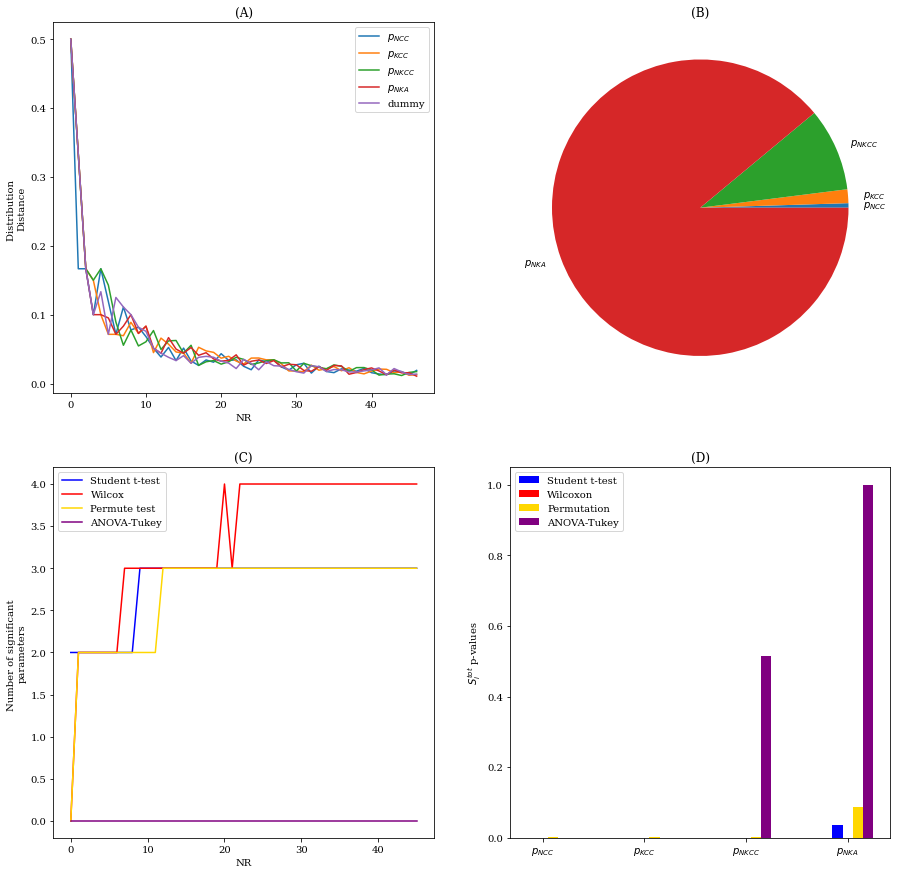

In [30]:
## MeFAST results - Total order sensitivity indices S_i

S_i, id_i = MeFAST_analysis('efast_pump_leak_data.npz',
                            Alpha=0.05,
                            type_SI='Si',
                            y_var='w',
                            time_id='ss',
                            parameter_labels=parameter_labels
                            )

Compiling MeFAST result for  Sti
Measuring convergence
Performing hypothesis testing


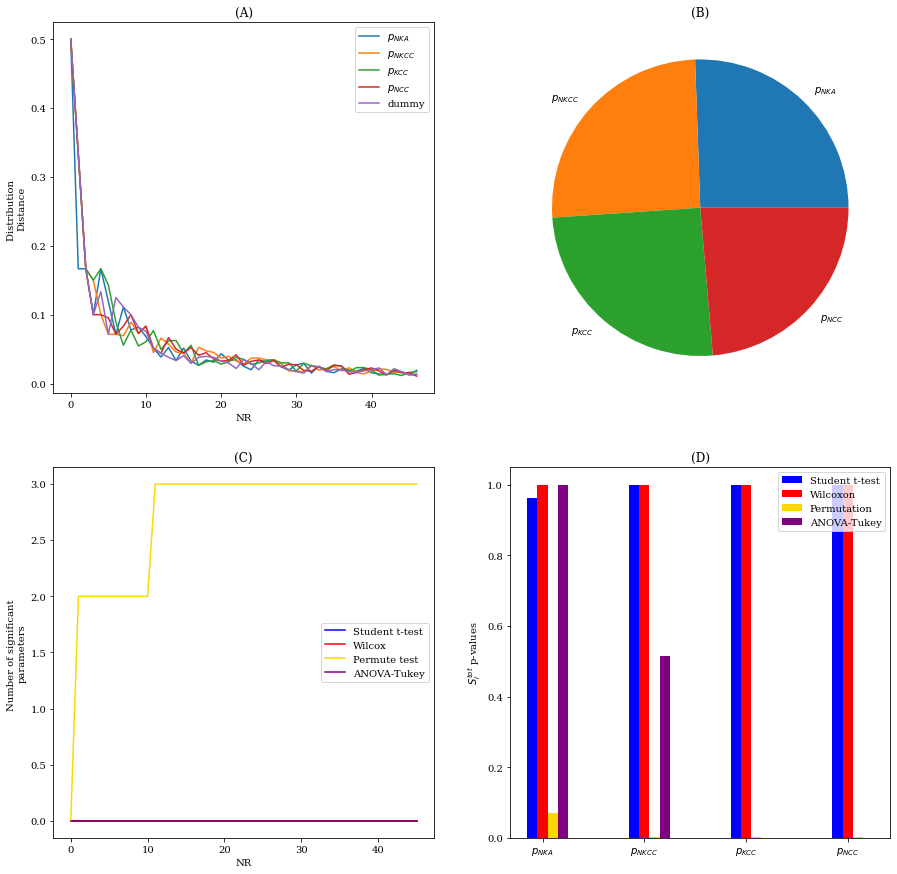

In [28]:
## MeFAST results - Total order sensitivity indices S_tot

St_i, idt_i = MeFAST_analysis('efast_pump_leak_data.npz',
                            Alpha=0.05,
                            type_SI='Sti',
                            y_var='w',
                            time_id='ss',
                            parameter_labels=parameter_labels
                            )

Parameter | Sti
$p_{NKA}$        | 0.9931573372748498
$p_{NKCC}$        | 0.9893109487404741
$p_{KCC}$        | 0.9255525754219475
$p_{NCC}$        | 0.29733416453018935
dummy        | 0.9994653825459544


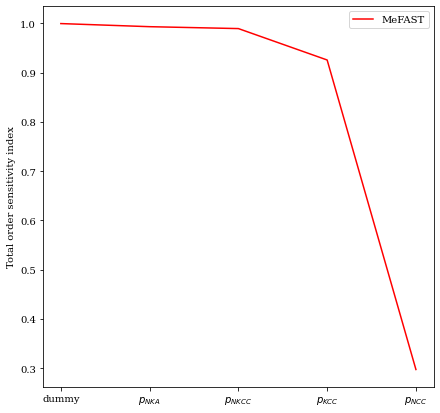

In [50]:
SI_fig('efast_pump_leak_data.npz',
       type_SI='Sti',
       y_var='w',
       time_id='ss',
       parameter_labels=parameter_labels)

# Notes

The arrays **pnka_array**, **pnkcc_array**, **pkncc_array**, and **pncc_array** are of length defined by the variable **samples_in_each_range_size**. The values in these arrays are linearly spaced between 0 and some maximum paramter value.

The variable **samples_in_each_range_size** can be thought of as the resolution of **group_1**. If there are $n$ cotransporters in the search, then there will be **samples_in_each_range_size**$^{n+1}$ parameter points.

The each row of array **group_1** is a parameter point and each column of **group_1** is a value associated with a particular parameter. As an example, **group_1** has the following form:

| Parameter point | $p_{NKA}$ | $p_{NKCC}$ | $p_{KCC}$ | $p_{NCC}$ |
|-:|-:|-:|-:|-:|
| Parameter point 1 | 0 | 0 | 0 | 0 |
| Parameter point 2 | 0 | 0 | 0 | 0.00025 |
| . . . | | | | |

The array **group_2** is the same shape as **group_1** with unifromly distributed parameter points between the same values defined in each parameter array.

# Pump and Three Cotransporters

## $p_{NKA}$, $p_{NKCC}$, $p_{KCC}$, and $p_{NCC}$

A dummy parameter is also included.

### Collect samples

In [ ]:
# Number of samples
Nsamples = 10000

# Time points
timepoints = np.array([-1])

# Minimum, maximum, and baseline parameter values. This includes a dummy 
# parameter that does not affect the model output. It should be assigned with 
# with zero sensitivity indices. However, MeFast will assign the dummy parameter
# with a small, non-zero value. The dummy parameter is indexed last for the 
# MeFAST algorithm.
pnka_min = 0
pnkcc_min = 0
pkcc_min = 0
pncc_min = 0
dummy_min = 1
p_min = np.array([pnka_min,
                  pnkcc_min,
                  pkcc_min,
                  pncc_min,
                  dummy_min])
pnka_max = 1.5*pnka
pnkcc_max = 2.5*pnkcc
pkcc_max = 0.25*pkcc
pncc_max = 0.015*pncc
dummy_max = 10
p_max = np.array([pnka_max,
                  pnkcc_max,
                  pkcc_max,
                  pncc_max,
                  dummy_max])
dummy = 1
baseline = np.array([pnka,
                     pnkcc,
                     pkcc,
                     pncc,
                     dummy])

# Number of parameters
Nparams = len(p_min)

# Initial sample A
threshold = 1e+300
A = np.zeros((Nsamples,Nparams))
for index in range(Nparams):
    A[:,index] = LHS_Call(p_min[index],
                          baseline[index],
                          p_max[index],
                          0,
                          Nsamples,
                          'unif',
                          threshold)

# Simulate baseline model output for each row of LHS matrix.
Y_A = np.zeros((Nsamples,1))
for index in range(Nsamples):
    parameter_point = A[index].copy()
    params.pnka = parameter_point[0]
    params.pnkcc = parameter_point[1]
    params.pkcc = parameter_point[2]
    params.pncc = parameter_point[3]
    Y_A[index] = CollectSample(params)

# Perturb each parameter by some \delta x_i while others are fixed.
# (Implemented in next for loop.)
dp_vec = np.diff(A.copy(), axis=0)
dp_vec = abs(dp_vec.min(axis=0)).copy()
dp = np.diagflat(dp_vec).copy()

# For each row j of LHS matrix make k copies.
A_dp = []
for row in range(Nsamples):
    A_dp_i = np.zeros((Nparams,Nparams))
    for copies in range(Nparams):
        A_dp_i[copies,:] = A[row,:].copy()
    A_dp_i = A_dp_i.copy() + dp.copy()
    A_dp.append(A_dp_i.copy())

# Simulate baseline model output for each modified jth row of LHS.
Y_dp = []
for matrix in A_dp:
    A_dp_i = matrix.copy()
    Y_dp_i = np.zeros((Nparams,1))
    for index in range(Nparams):
        parameter_point = A_dp_i[index].copy()
        params.pnka  = parameter_point[0]
        params.pnkcc = parameter_point[1]
        params.pkcc  = parameter_point[2]
        params.pncc  = parameter_point[3]
        Y_dp_i[index] = CollectSample(params)
    Y_dp.append(Y_dp_i.copy())

# Compute derivative matrix.
dY = np.zeros((Nsamples,Nparams))
for row in range(Nsamples):
    dY[row,:] = (Y_dp[row] - Y_A[row]).flatten() / dp_vec.flatten()

# Compute relative derivative matrix.
S = np.zeros_like(dY)
for row in range(Nsamples):
    for column in range(Nparams):
        S[row,column] = dY[row,column] * A[row,column] / Y_A[row]

### Bonferroni Correction

In [ ]:
p = 0.05
p_corrected = p/Nparams

### DGSM ratio and Gi for each parameter

In [ ]:
# Taking avergae and standard deviation of each column of 
# the relative derivative matrix.
mu = np.zeros(Nparams)
sd = np.zeros(Nparams)
Gi = np.zeros(Nparams)
ratio = np.zeros(Nparams)
for column in range(Nparams):
    mu[column] = np.mean(abs(S[:,column]))
    sd[column] = np.std(abs(S[:,column]))
    Gi[column] = (mu[column]**2 + sd[column]**2)**0.5
    ratio[column] = mu[column] / sd[column]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
parameter_labels = ['$p_{NKA}$ ', '$p_{NKCC}$', '$p_{KCC}$ ', '$p_{NCC}$ ', '$dummy$   ']

print('Parameter  | Ratio               | G_i                   ',
      '\n______________________________________________________________')
for parameter in range(Nparams):
    print(parameter_labels[parameter], '|', ratio[parameter], '|', Gi[parameter])

Parameter  | Ratio               | G_i                    
______________________________________________________________
$p_{NKA}$  | 0.24048520359402786 | 0.013171005714765684
$p_{NKCC}$ | 0.3524708036151446 | 1.8756956605266597
$p_{KCC}$  | 1.903040547737319 | 0.03708152284283909
$p_{NCC}$  | 0.31855739321269455 | 1.5670658246603442
$dummy$    | nan | 0.0


### Plot of ratio and $G_i$

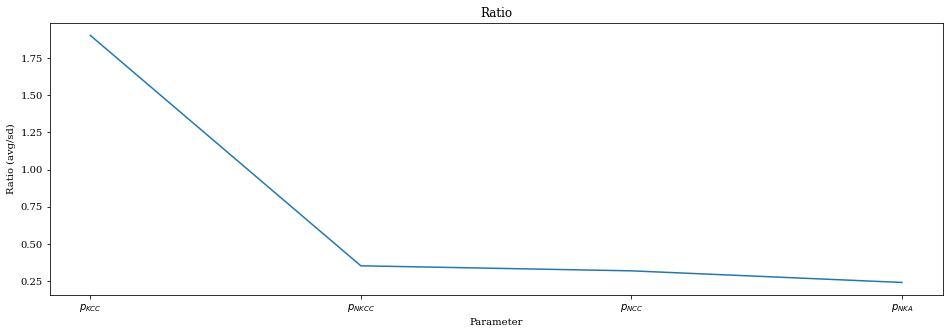

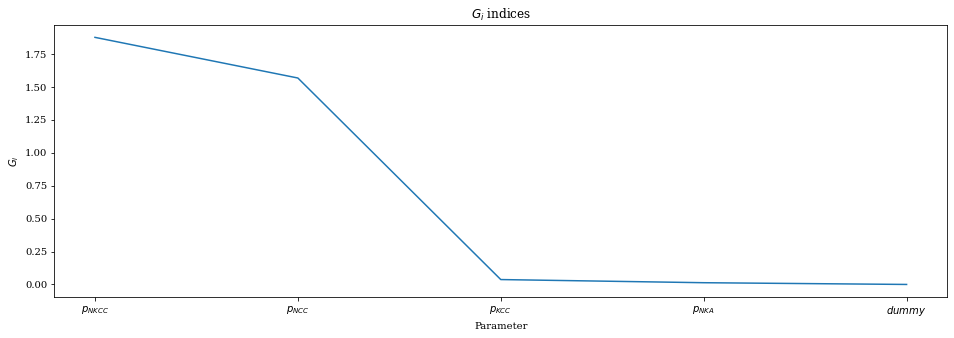

In [ ]:
parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$', '$dummy$']

# Plot ratio
plt.figure(figsize=(16,5))
mask = np.flip(np.argsort(ratio))
x_ax =[]
y_ax = []
for parameter in mask:
    x_ax.append(parameter_labels[parameter])
    y_ax.append(ratio[parameter])
plt.plot(x_ax, y_ax)
plt.xlabel('Parameter')
plt.ylabel('Ratio (avg/sd)')
plt.title('Ratio')
plt.show()

# Plot Gi
plt.figure(figsize=(16,5))
mask = np.flip(np.argsort(Gi))
x_ax =[]
y_ax = []
for parameter in mask:
    x_ax.append(parameter_labels[parameter])
    y_ax.append(Gi[parameter])
plt.plot(x_ax, y_ax)
plt.xlabel('Parameter')
plt.ylabel('$G_i$')
plt.title('$G_i$ indices')
plt.show()

### 2D plots: parameter vs volume ss

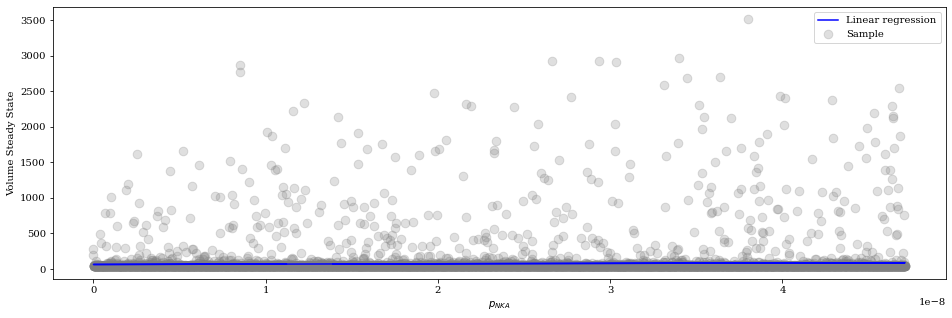

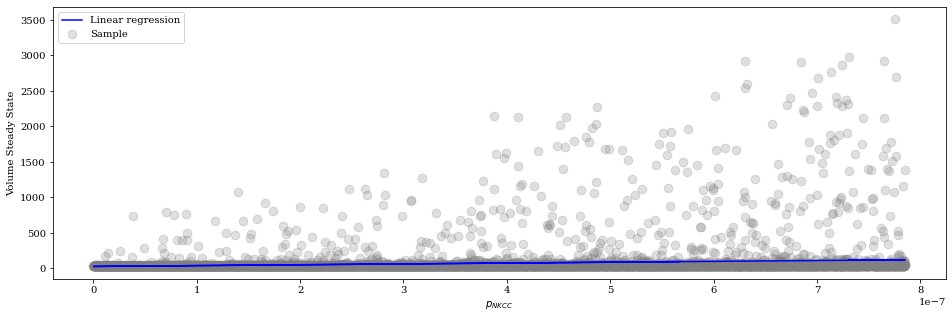

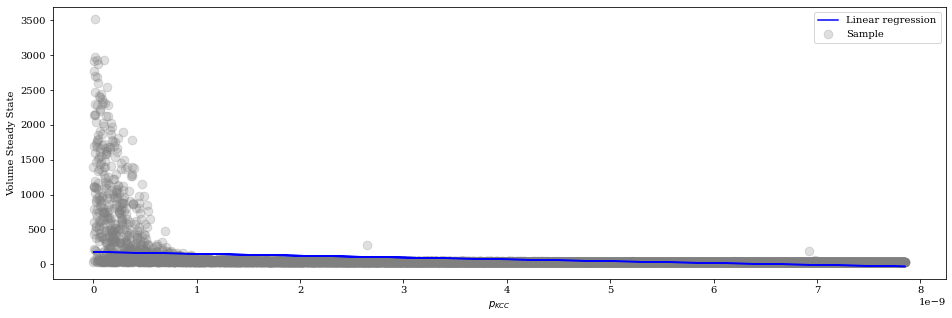

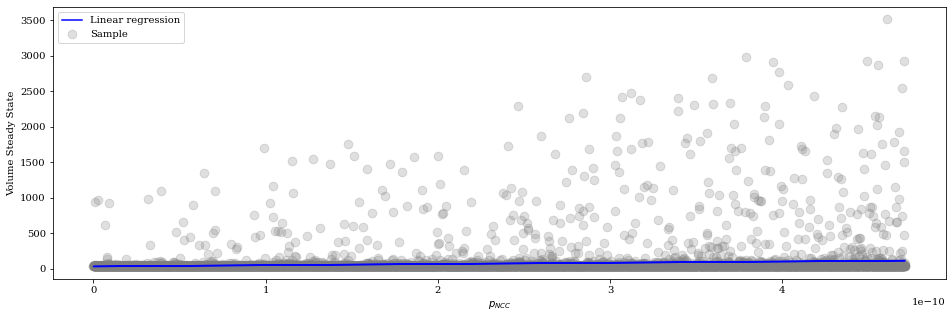

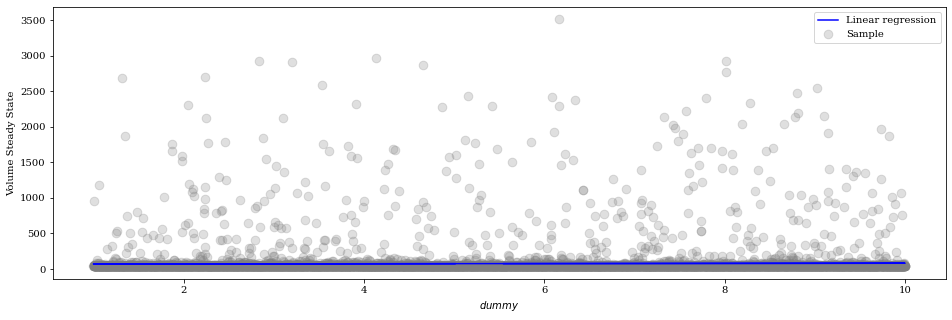

In [ ]:
## Plotting in 2D

parameter_labels = ['$p_{NKA}$', '$p_{NKCC}$', '$p_{KCC}$', '$p_{NCC}$', '$dummy$']

x_ax = A
y_ax = Y_A

for parameter in range(len(parameter_labels)):
    plt.figure(figsize=(16,5))
    
    # Linear regression
    X = np.hstack((
        np.reshape(x_ax[:,parameter], (-1,1)),np.reshape(np.ones_like(x_ax[:,parameter]), (-1,1))
        ))
    coef = np.linalg.inv(X.T @ X) @ X.T @ y_ax

    plt.plot(x_ax[:,parameter], X @ coef, label='Linear regression', color='blue')

    # Samples
    plt.scatter(x_ax[:,parameter], y_ax, s=75, label='Sample', color='gray', alpha=0.25)

    plt.xlabel(parameter_labels[parameter])
    plt.ylabel('Volume Steady State')
    plt.legend(loc='best')
    plt.show()